# Outlier Analysis of Lending Club

In [2]:
# Importing dependencies
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(color_codes=True)

import pandas_profiling

# from imbalanced-learn as imblearn
from scipy import stats, integrate
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn import preprocessing

from sklearn.feature_selection import RFE #Recursive Feature elemination
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split

from sklearn import model_selection
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from sklearn.metrics import confusion_matrix

# For precision , recall
from sklearn.metrics import classification_report

# ROC, AUC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn.feature_selection import RFE #Recursive Feature elemination
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split

import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

## Read in dataset

In [3]:
df = pd.read_csv(r'C:\Users\jessm\Box\Lending Club\loans_data_green_1.csv',sep=",")
df.head()
pandas_profiling.ProfileReport(df)


In [4]:
# print(df.head())
# print(df.shape)
cols=df.columns.values
cols

array(['Unnamed: 0', 'acc_open_past_24mths', 'grade', 'Year',
       'addr_state', 'annual_inc', 'bc_util', 'dti', 'emp_length',
       'inq_last_6mths', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op',
       'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_il_tl',
       'num_bc_sats', 'open_acc', 'pub_rec_bankruptcies', 'pub_rec',
       'recoveries', 'tot_cur_bal', 'total_bc_limit'], dtype=object)


## Create new variable binning employee length information
## Remove duplicates and drop NAs 

In [5]:
df["emp_length_new"] = np.where(df['emp_length']=="10+ years", "10+ years",
                                     np.where(np.isin(df['emp_length'], ["1 year",'2 years','3 years','4 years','5 years']), "1-5 years",
                                              np.where(np.isin(df['emp_length'], ['6 years','7 years','8 years','9 years']), "6-9 years",
                                                       np.where(np.isin(df['emp_length'], ["< 1 year"]), "<1 year", "n/a"))))

In [8]:
df.head()
df=df.drop(["Unnamed: 0" ], axis=1)
print(df.head())

   acc_open_past_24mths grade    Year addr_state  annual_inc  bc_util    dti  \
0                   6.0     A  2014.0         FL    324388.0     39.3   9.35   
1                   3.0     B  2014.0         CA     41500.0     78.9  26.55   
2                   9.0     C  2014.0         CA    165000.0     68.2  27.36   
3                   8.0     E  2014.0         CA     67000.0     30.3   8.90   
4                   9.0     C  2014.0         MD    115000.0     80.0  23.01   

  emp_length  inq_last_6mths  mo_sin_old_rev_tl_op       ...        \
0    5 years             1.0                 157.0       ...         
1    6 years             1.0                 180.0       ...         
2    8 years             0.0                 305.0       ...         
3     1 year             1.0                 162.0       ...         
4   < 1 year             0.0                 165.0       ...         

   num_actv_bc_tl  num_il_tl  num_bc_sats  open_acc  pub_rec_bankruptcies  \
0             5.0    

In [9]:
df=df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
print(df.shape)


(428593, 25)


## Create dummy variable (One hot encoding) for categorical variables.  

In [10]:
cols_to_transform = [ 'emp_length_new']
df2 = pd.get_dummies(df,  columns = cols_to_transform, drop_first = True)
# lendclub1.describe(include = "all").transpose()
df2.head()
# # Converting % string variables to numeric
# lendclub2["int_rate_new"]  = pd.to_numeric(lendclub2["int_rate"].str.replace("%", ""))
# lendclub2["revol_util_new"]  = pd.to_numeric(lendclub2["revol_util"].str.replace("%", ""))


acc_open_past_24mths grade    Year addr_state  annual_inc  bc_util    dti  \
0                   6.0     A  2014.0         FL    324388.0     39.3   9.35   
1                   3.0     B  2014.0         CA     41500.0     78.9  26.55   
2                   9.0     C  2014.0         CA    165000.0     68.2  27.36   
3                   8.0     E  2014.0         CA     67000.0     30.3   8.90   
4                   9.0     C  2014.0         MD    115000.0     80.0  23.01   

  emp_length  inq_last_6mths  mo_sin_old_rev_tl_op           ...            \
0    5 years             1.0                 157.0           ...             
1    6 years             1.0                 180.0           ...             
2    8 years             0.0                 305.0           ...             
3     1 year             1.0                 162.0           ...             
4   < 1 year             0.0                 165.0           ...             

   num_bc_sats  open_acc  pub_rec_bankruptcies  pub_rec  recoveries  \
0          7.0      23.0                   0.0      0.0         0.0   
1          4.0      12.0                   0.0      0.0         0.0   
2          7.0      15.0                   0.0      0.0         0.0   
3          3.0      11.0                   1.0      1.0         0.0   
4          8.0      23.0                   0.0      0.0         0.0   

   tot_cur_bal  total_bc_limit  emp_length_new_10+ years  \
0     524448.0         89700.0                         0   
1     226755.0         14900.0                         0   
2     624546.0         23000.0                         0   
3     108741.0          6600.0                         0   
4     365826.0         30300.0                         0   

   emp_length_new_6-9 years  emp_length_new_<1 year  
0                         0                       0  
1                         1                       0  
2                         1                       0  
3                         0                       0  
4                         0                       1  

[5 rows x 27 columns]

In [11]:
###Drop columns for outlier detection

X=df2.drop(['grade', 'Year', 'addr_state', 'emp_length'], axis=1)
print(X.head(2))
X.shape

   acc_open_past_24mths  annual_inc  bc_util    dti  inq_last_6mths  \
0                   6.0    324388.0     39.3   9.35             1.0   
1                   3.0     41500.0     78.9  26.55             1.0   

   mo_sin_old_rev_tl_op  mo_sin_rcnt_rev_tl_op  mo_sin_rcnt_tl  mort_acc  \
0                 157.0                    3.0             3.0       1.0   
1                 180.0                   10.0            10.0       3.0   

   mths_since_recent_bc           ...            num_bc_sats  open_acc  \
0                   3.0           ...                    7.0      23.0   
1                  10.0           ...                    4.0      12.0   

   pub_rec_bankruptcies  pub_rec  recoveries  tot_cur_bal  total_bc_limit  \
0                   0.0      0.0         0.0     524448.0         89700.0   
1                   0.0      0.0         0.0     226755.0         14900.0   

   emp_length_new_10+ years  emp_length_new_6-9 years  emp_length_new_<1 year  
0                     

(428593, 23)

In [12]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X)
X_std = sc.transform(X)

   

In [13]:
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

##  Isolation Forest For outlier detection


In [14]:
clf = IsolationForest(n_estimators= 100,contamination =0.002, max_samples=1000, max_features = 9,random_state=10)
clf.fit(X)
y_pred_train = clf.predict(X)
# y_pred_test = clf.predict(x_test)

import scipy
y_pred_train
scipy.stats.itemfreq(y_pred_train)

array([[    -1,    858],
       [     1, 427735]], dtype=int64)

In [15]:
clf1 = IsolationForest(n_estimators= 100,contamination =0.002, max_samples=1000, max_features = 3,random_state=10)
clf1.fit(X)
y_pred_train1 = clf1.predict(X)
# y_pred_test = clf.predict(x_test)

import scipy
y_pred_train1
scipy.stats.itemfreq(y_pred_train1)

array([[    -1,    858],
       [     1, 427735]], dtype=int64)

In [45]:
clf2 = IsolationForest(n_estimators= 100,contamination =0.002, max_samples=1000, max_features = 13,random_state=10)
clf2.fit(X)
y_pred_train2 = clf2.predict(X)
# y_pred_test = clf.predict(x_test)

import scipy
y_pred_train2
scipy.stats.itemfreq(y_pred_train2)

C:\Users\jessm\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\jessm\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  


array([[    -1,    858],
       [     1, 427735]], dtype=int64)

In [46]:
clf3 = IsolationForest(n_estimators= 100,contamination =0.002, max_samples=1000, max_features = 20,random_state=10)
clf3.fit(X)
y_pred_train3 = clf3.predict(X)
# y_pred_test = clf.predict(x_test)

import scipy
y_pred_train3
scipy.stats.itemfreq(y_pred_train3)

C:\Users\jessm\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\jessm\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  


array([[    -1,    858],
       [     1, 427735]], dtype=int64)

In [47]:
###Get anomaly Score 
anomaly_score = clf.decision_function(X)
anomaly_score
#https://stats.stackexchange.com/questions/335274/scikit-learn-isolationforest-anomaly-score


array([ 0.05679384,  0.10236006, -0.03323972, ...,  0.00453226,
        0.08196025,  0.11186825])

## Eliptic Envelope for outlier detection

In [48]:
# EllipticEnvelope(store_precision=True, assume_centered=False, support_fraction=None, contamination=0.1, random_state=None)[source]¶
from sklearn.covariance import EllipticEnvelope

In [49]:
elp = EllipticEnvelope(contamination = 0.002)

In [62]:



elp1 = EllipticEnvelope(store_precision=True, assume_centered=False, support_fraction=None, random_state=None, contamination = 0.002, )
elp1.fit(X)
y_pred_elp1 = elp1.predict(X)

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (96.641246679518503 > 94.748051202145263)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (96.557736293554868 > 95.257378554408533)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.605283488505023 > 94.601952197621699)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (96.585885348183922 > 95.934006270039077)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (97.4785

In [63]:
elp.fit(X)
y_pred_elp = elp.predict(X)


C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (96.819006825246177 > 96.438723777384226)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (96.273227189575024 > 80.863073886696426)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.390275992625291 > 98.178480602654233)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (97.576612918840851 > 97.471705999958786)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.0857

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.227049530728891 > 89.662125971929854)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (100.815946239671092 > 81.958670599136966)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.156084197309369 > 89.056532474506668)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.402033453496273 > 88.915404867103362)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.212

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.760464216873856 > 89.169024869065652)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.964479397626491 > 88.856624460977642)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.780928628071990 > 89.148323682746010)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.384194460570640 > 89.573209017428596)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.4475

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.065958321867612 > 88.920249978767060)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.173474116908537 > 88.973498415667265)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.629649170254922 > 89.086181782461367)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.584987564568948 > 89.076493281749777)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.5915

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.519096537457727 > 89.171106382863258)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.681266794722873 > 89.263603341829565)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.360374550397665 > 89.025026951966922)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.493240988457856 > 89.066822672932503)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.2514

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.508012886683005 > 89.132979929899378)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.448239218096319 > 89.007857507662678)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.891079794447393 > 89.207613259817009)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.516909250718285 > 89.147454065220344)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.8725

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.050263483406226 > 88.964975730008561)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.752407237748784 > 89.097793724505323)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.969802420317436 > 88.895677059140496)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.737516579395347 > 89.139034527089592)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.0075

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.826475768687629 > 89.256912175148472)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.289242515054369 > 89.152250447824713)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.271134099658227 > 89.480019412322804)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.229714873120002 > 89.393311277317650)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.6689

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.096863844285267 > 88.926923767861638)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.504777518699527 > 89.108495472012493)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.738697794050935 > 89.112865319258518)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.671868016002193 > 89.261931679359307)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.9679

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.798874008711309 > 89.144450378229152)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.115769275898060 > 88.983728795094720)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.115832557084730 > 89.014097058790540)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.777127875733640 > 89.134405119395339)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.7895

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.813053549860356 > 88.943231197853706)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.825212086811447 > 89.335422310196336)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.810714362589607 > 89.225148645323856)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.144219353849536 > 88.907686664452896)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.2079

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.104912909221213 > 88.972012640787966)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.814976903937946 > 89.101518852253122)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.740234530698373 > 89.226485079726672)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.816086190012868 > 89.277933462020528)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.0843

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.819142332257400 > 88.991531960029718)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.051862686609155 > 88.940885567259130)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.116192018446768 > 88.978823241687408)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.797202543137345 > 89.154056629751295)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.7790

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.499286832738093 > 89.112742650021133)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.671463854495130 > 88.850537451302060)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.532266365602894 > 88.916574738159923)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.432901860685234 > 88.947987017713984)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.0310

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.122999265833926 > 88.925769883633322)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.145333239235626 > 88.970160713590602)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.121016314534472 > 88.938359119992654)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.786641535211544 > 89.229052271303885)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.7956

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.817809481646222 > 89.320258166717679)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.783159635993584 > 89.154418582889988)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.013484655009535 > 88.942656839236733)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.031124341371566 > 89.064222415588546)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.0720

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.480231258585491 > 89.215197685043833)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.639659276613045 > 89.227611779108855)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.669983169227436 > 89.169304672366664)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.189076344517133 > 89.031659188603555)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.7316

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.881176371368554 > 89.161831736417284)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.920484286612179 > 89.050509636134080)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.127180372862938 > 89.193654832184365)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.003786463633986 > 88.867078555314251)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.0075

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (101.080017003105098 > 81.851395250969006)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (100.850191042770803 > 81.918515789655586)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (101.023807953412387 > 81.856176769997361)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (100.825559735068623 > 81.881184961721800)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.145793029925301 > 88.914176719379469)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.672034700836718 > 89.098269219731264)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.620379826210268 > 89.143635466448984)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.453833619182163 > 88.873526264794876)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.8488

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.089856971969681 > 89.829584222768830)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.727589179390392 > 89.756096297731844)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.087422257859799 > 89.105135020622328)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.281071684296464 > 89.365913770231757)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.7807

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.139018057379403 > 88.870187710939092)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.761996646094019 > 89.164018534093117)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.436347352432875 > 89.082415863940057)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.823262840085903 > 89.130848185229070)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.7291

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.322295156369989 > 88.927507515967207)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.792266678658763 > 89.026928415009834)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.311464494205325 > 88.963357666194483)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.992436362653635 > 88.871555793931421)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.0075

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.864189992035051 > 89.234173073152448)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (100.708365643248257 > 82.913442125861110)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (101.080969362901257 > 82.415742058401946)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (101.068123892517761 > 82.472072830874851)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.8

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.493034703781092 > 89.083130910733331)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.572842166553443 > 89.137102400416410)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.673164196886418 > 89.112005932471817)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.790401050933937 > 89.225090212329150)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.6933

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.686333379762900 > 89.097610972991475)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.823885839554848 > 89.153952828819129)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.764020826277317 > 89.156243543481352)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.526403095511341 > 89.383410294694656)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.4656

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.903461095254599 > 89.276111449174465)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.834070451481026 > 89.216485707077993)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.831199997530689 > 89.248900172332455)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.765482189406953 > 89.271071196616091)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.8495

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.594418927610306 > 89.146492176093489)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.689547552773831 > 89.224622845149426)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.844375323979506 > 89.219981360316680)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.126386815925542 > 88.943340681145614)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.1195

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.948656546594151 > 89.369236911201298)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.123879037102000 > 89.125414934880254)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.112026761280177 > 89.064953804532735)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.530419045012422 > 89.119196890963906)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.4485

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.821914675305038 > 88.970070082534278)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.854364958011857 > 89.228506372604144)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.777801631644493 > 89.164464835572772)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.168211009453529 > 88.965794227934509)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.6255

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.768151409462220 > 88.908359065705454)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.812221274477054 > 89.015040677334170)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.889376013118934 > 89.050393278994122)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.769991181342633 > 89.020136140398122)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.6245

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.074208451893369 > 88.993821842463134)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.102775896663388 > 88.907975279757451)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.564091573600763 > 88.903585712714062)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.123597158506115 > 89.001342541817891)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.4610

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.858514524465889 > 89.264242036171353)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.261192666405577 > 88.930718700951360)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.022388339667089 > 88.974424507996574)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.149206462238013 > 88.956692754328301)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.0818

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.788295854885988 > 89.346741589417121)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.103914060615637 > 88.974655103878902)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.095352947061244 > 88.997133638134429)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.829558873915488 > 89.038267210774137)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.8248

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.740312942688263 > 89.118383069369941)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.819423330279960 > 89.128959461146891)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.193130183916779 > 89.086567766557039)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.241076552926046 > 89.248307697811555)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.3009

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.006063035446360 > 88.878663367320129)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.707777392344880 > 88.877548644606250)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.710781504829484 > 88.950936429186442)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.122441754251000 > 88.937164699943793)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.6918

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.138525748711487 > 88.949703385044344)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.133759315289367 > 88.990340233731928)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.782884136044103 > 88.889695798641981)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.134166839345710 > 89.047261603031373)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.8508

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.872699189117270 > 89.522808958792012)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.550466894059113 > 89.364731202752580)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.868662804394774 > 89.632960766666571)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.433376858487165 > 89.379006299006733)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.8352

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.064928276463803 > 88.920120258215789)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.055473497223375 > 88.929463838414279)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.724468656421706 > 89.164076998256661)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.450953396099706 > 89.008258093589447)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.4034

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.757751506088042 > 89.028346938508065)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.181764618979216 > 88.900855960108657)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.705844910716479 > 89.382681035623378)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.596778699350224 > 89.285253771241926)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.2431

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.916811956038430 > 89.256496381044855)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.162267538161004 > 89.194828923696107)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.445157413048406 > 89.226938031278493)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.825510706599744 > 89.143797593652977)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.1682

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.778676291999986 > 89.575962453941600)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.000184959529420 > 89.310948024389802)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.547208145851897 > 89.459690713758079)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.567677178939377 > 89.496111012866976)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.5503

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.143802433402911 > 89.006932344723481)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.182008835670970 > 89.126893491453117)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.864703888353844 > 88.975421679137682)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.882492422767029 > 89.026917736127643)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.1815

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.378503326389293 > 89.575759844693295)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.972039547884506 > 88.806465942502882)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.981342087927715 > 88.886039698646073)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.008895808829806 > 88.868413448840315)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.9852

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.231925769163226 > 88.853224607140703)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.689701848265358 > 88.925680280570958)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.501018202282623 > 89.133873540949949)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.682590839700978 > 88.875575426859058)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.0383

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.390618084770196 > 89.228605508381719)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.593188744323655 > 89.063913549023553)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.881113642179841 > 89.300517007001815)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.915317573921769 > 89.035257619142413)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.0599

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.817939926882104 > 89.221514931131082)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.118725116446385 > 88.984898094691545)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (100.749351161352621 > 82.684137629462995)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (100.661311999585379 > 82.619648873344019)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.25

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.994620046573189 > 88.926594818237334)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.093989157298992 > 88.907756842086727)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.783248908136002 > 89.229241608419230)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.721487680913413 > 88.924073293163758)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.5444

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.703614635865577 > 88.961368361537367)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.670460030132716 > 89.155137012711918)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.089943096602624 > 89.024820104636134)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.916324941615983 > 89.360309220819190)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.8676

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.110744396580742 > 89.272608882534243)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.109286722569280 > 89.449873664158531)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.834574223465538 > 89.224886628527344)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.418778445292887 > 88.903281410919021)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.2693

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.590831153656808 > 89.332237397357048)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.079925604555470 > 88.940194993383031)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.745772145342983 > 89.148000799396698)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.006459388561822 > 88.861374661161392)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.7921

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.316462059816246 > 89.328727072856793)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.169764711964604 > 88.976411619496076)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.816802800807309 > 88.996365570926343)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.590902602348180 > 89.022712496612087)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.8735

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.757709262882628 > 89.046247546933401)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.503402478006763 > 89.099756226288136)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.051980161038841 > 88.874385211357080)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.034990577398588 > 89.011731476761014)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.7467

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.124228396217504 > 89.021181338815481)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.388963061894131 > 89.024579079655481)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.874821673403375 > 89.398886379132946)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.509852182238149 > 89.253098958023457)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.3928

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.972062276506179 > 88.802646900383081)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.736168862738722 > 88.938714290766100)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.966168123234908 > 88.836633932647047)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.784130017804998 > 89.146392542176386)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.5169

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.715003580746256 > 89.091969989941859)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.462331437717154 > 89.004070110877905)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.948358985005285 > 88.850738994850815)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.782052244252839 > 89.099529396240598)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.9708

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.932451012848162 > 89.165050221012706)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.582401883382659 > 89.225165228775921)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.642734722787296 > 89.247082458632462)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.278333295816779 > 89.545650146177778)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.6716

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.110105280710329 > 89.028802298110136)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.160786138215400 > 89.132183358859336)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.132786164349071 > 89.045059951497024)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.147813550793771 > 89.094690621390910)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.1415

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.135420609307900 > 88.907836026391308)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.767899898986144 > 89.170138988137282)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.046653580789268 > 88.876804225597454)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.800663338519897 > 89.112103687370947)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.9731

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (100.741717126788487 > 82.959081243540354)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.881901403962146 > 89.594268576369203)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.216793154158580 > 89.123405265342086)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.936503740305369 > 89.442335658744597)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.917

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.062627125015652 > 88.860093851093950)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.983751914811705 > 88.881543031043591)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.732239972531829 > 89.053783998033381)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.156266580501324 > 88.865389075278785)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.7006

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.657483191322214 > 88.864700950805144)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.988164943080292 > 88.900664539533636)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.763246451981061 > 88.956061751433140)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.626771435832921 > 89.020141948825341)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.6745

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.392632593403889 > 89.474254215072278)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.415615047604689 > 89.554966183085440)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.840901305217486 > 89.173042905014626)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.059865094694317 > 88.876317719844522)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.8014

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.108966883731497 > 89.026785444661712)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.105034816822325 > 88.991029151683335)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.115562972955956 > 88.942897812024214)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.115883444461161 > 89.089763018314088)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.0495

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.841905038677666 > 89.214407104226481)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.174076593223162 > 88.962390736140776)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.827322700301622 > 89.194514234553282)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.782199964869164 > 89.247073796501851)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.4612

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.399720439854775 > 89.115582662140000)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.746824318132610 > 89.098816549008987)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.008462634242861 > 88.880060341906415)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.851797093740331 > 89.349985332211801)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.8731

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.021318156573358 > 88.872182126234165)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.951037794984529 > 89.362711446821677)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.175418228699201 > 89.134178269783717)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.353193969114940 > 89.477540450439548)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.0826

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.168048424377432 > 89.056136067540763)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.998064597549629 > 88.868688508904100)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.097240720475384 > 88.843350091630668)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.045715742968753 > 88.904905119713547)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.0379

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.966051025427035 > 88.867804025601814)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.747071602380643 > 89.172814833389040)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.326418148518570 > 89.447259984013996)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.310240051032778 > 89.392846167981546)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.1815

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.161722808652669 > 89.026792078552745)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.971163755842696 > 88.869641843504439)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.824737466387091 > 88.994581187364517)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.731505384406191 > 88.986869849398843)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.7383

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.895786030717957 > 89.091036586608823)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.381058640433949 > 88.877315157537282)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.375299916735855 > 88.845976963724638)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.138447999868745 > 88.938761584801526)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.3500

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.129441510692544 > 88.915454620266203)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.851255708555072 > 88.914286827413875)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.108741800015167 > 88.851951195194985)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.992457143847005 > 88.906673668468798)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.9981

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.082163823127999 > 88.988217460943304)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.848280635812230 > 89.271525317470420)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.733203253351391 > 89.115711024936815)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.742851372397325 > 89.093220582493643)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.7334

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.506010974620011 > 89.043779960650937)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.718150384808169 > 88.898036979930069)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.937934331822703 > 88.874682228917607)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.671615437839279 > 88.858896105850093)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.0385

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.821317400240432 > 89.152386612138486)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.948706545332684 > 90.183177433094230)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.771023907311616 > 89.419533464348476)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.837567112940974 > 89.866443537832453)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.6721

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.017922598105244 > 88.890956425263312)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.940580910332613 > 89.438200119770698)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.884867294088878 > 89.414583047137356)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.158833027659085 > 89.136710593957190)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.9685

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.751350808914978 > 89.142654625859279)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.979065869894711 > 88.821019891839057)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.767486915326657 > 89.082215418074554)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.754649936593623 > 88.879420928056362)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.9105

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.793122147018522 > 89.310517409475580)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.118150924362482 > 89.024550650652870)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.422564753391100 > 89.227816382236426)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.317651727477724 > 88.924492447238194)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.8817

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.195951766924978 > 89.086513147169669)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.539457412669904 > 89.067382737743117)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.149913746158276 > 89.024836987359237)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.215205333099178 > 89.026282223972871)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.9338

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.879045536345572 > 89.259550935935849)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.893561645484638 > 89.258951469221799)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.165692160840550 > 89.041347642469290)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.432012231712591 > 89.103241953630416)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.3608

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.056829428899306 > 88.957765453877542)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.027251674686056 > 88.938567284388100)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.194099298279156 > 89.285296053488949)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.298421412485126 > 89.339816610649137)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.3570

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.825436722919719 > 89.239323958573422)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.054705673957372 > 88.878116288365717)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.874196878780353 > 89.049726435082960)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.843087509285454 > 88.853583262256649)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.7593

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.102784286500338 > 89.038524732859514)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.890830157970925 > 89.314060537571834)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.918691709917525 > 89.314315290716266)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.236745897488277 > 89.356098417124372)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.3617

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.804684949645889 > 89.614514144666558)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.738273533764414 > 89.747462953767268)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.806220313585058 > 89.505388918393635)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.992276764999488 > 88.884066066986492)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.0104

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.739385889060515 > 89.376519917372903)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.721561957916521 > 89.361513664056261)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.001197502657689 > 88.945066217369003)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.460106652219451 > 89.010768631748775)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.2582

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.008029978436653 > 88.896428853013191)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.694646469336078 > 88.921230041547773)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.179627385089987 > 88.870652216175642)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.645589137952129 > 89.152471267417170)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.5615

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.974289965179793 > 88.889911273437733)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.823094326829889 > 89.222247481119126)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.922004113635978 > 89.468685806748752)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.335406937842080 > 89.444435209363945)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.0802

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.167748842488706 > 88.864491343021456)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.197146337439733 > 88.908314860546028)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.892953101334768 > 89.367710366406669)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.303452531783464 > 89.078360774912653)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.2194

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.970013909804791 > 88.961036757931510)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.684439842257532 > 88.929760011816128)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.696304358706570 > 88.939089967393429)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.689918742521286 > 88.940677565162503)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.7578

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.830950458350586 > 89.262705843500612)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.132117853537551 > 88.944915134502565)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.089987091649107 > 89.064512604854812)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.976409888160603 > 89.430264979625747)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.8634

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.870630603665305 > 89.035301994525014)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.589279774319024 > 88.985282325426255)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.925205405296708 > 89.267088008230431)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.810714362589607 > 89.206125944907484)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.7295

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.086241249519247 > 89.249340118731013)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.014980528074133 > 88.980028389305829)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.719951717341502 > 88.994130061936616)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.806938871326466 > 88.996862021349827)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.7716

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.105485237046523 > 89.086898369682274)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.711977313875195 > 88.974386635234438)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.856664403407450 > 89.126235468577335)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.088826118833708 > 89.062563704559025)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.1128

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.924869877512521 > 89.283697030334736)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.481604780561398 > 88.981690785637454)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.804331247976720 > 89.209294329329111)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.897548089537736 > 89.216440717760236)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.0092

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.020720785187038 > 88.971959572276546)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.337309839993438 > 89.145164702556954)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.828110345156887 > 89.267193743789846)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.838699791458012 > 89.311653441664006)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.8259

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.717777391475366 > 89.024448735055444)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.637150965917300 > 88.840610458362775)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.995461646367062 > 88.870143175879306)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.733432460395434 > 89.103578806373875)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.7221

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.503201812634700 > 89.114995401392207)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.987061635765471 > 88.855026227750997)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.172049196891521 > 88.977144027193248)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.804539151119585 > 89.268785814118345)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (100.818

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.822992948955729 > 89.635425342496646)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.201755015482732 > 89.073728451569195)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.639800442553266 > 89.106549826022032)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.948664404120706 > 89.259561251534862)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.9423

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.843693097758745 > 89.398389104758607)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.159657217890640 > 89.186363779880054)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.827635865883508 > 89.276320310234567)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.763775602818214 > 88.931021293563418)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.9883

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.465403534479051 > 88.980119934783133)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.844510220822684 > 89.304238893008488)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.067336307314790 > 88.978211352522976)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.738067162212516 > 88.942115033246367)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.0901

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.152591515451206 > 89.029247516484958)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.836847965053906 > 89.033802954706047)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.875982672352336 > 89.339974960623451)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.111605832978483 > 88.860465220253303)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.6987

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.044470972624737 > 88.893700521657081)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.240406845875697 > 89.159238906506161)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.105538378641754 > 89.106267613987370)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.192620397768138 > 89.179837168177599)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.1959

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.276562826953111 > 89.184947462895792)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.173997620511386 > 89.159875382394432)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (100.879679015854094 > 81.889983800596511)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.006558232746784 > 88.885206600408281)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.765

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.408128520157220 > 89.460839763637793)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.394298632585887 > 89.363855776500785)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.096402905390150 > 89.693715294619437)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.321407176887121 > 89.420828477206129)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.3025

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.861375031853569 > 89.259972171315610)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.820432748515955 > 89.201466293253063)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.842552129295740 > 89.069439811877302)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.862707126055042 > 89.342771406927454)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.8377

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.049795426364099 > 88.906716354547427)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.727342542928781 > 88.897991905809647)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.809011086209821 > 88.994246445179883)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (100.965495708641100 > 81.895193654097795)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (100.65

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (100.899103109834087 > 81.837254406987000)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.711739522846173 > 88.921040377755247)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.015624106117045 > 88.956265626349293)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.764624629114678 > 88.968097801742715)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.821

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.824212491665335 > 89.338435327073654)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.682231662950016 > 88.944232650114870)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.860744591173074 > 88.915196392896092)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.661899770339744 > 88.942768492013144)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.0454

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.672346646170681 > 89.790986616752789)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.848179519470264 > 89.685625747291780)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.029089124559547 > 88.918762617244468)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.046648398207921 > 88.926818992634580)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.1692

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.877201944582055 > 89.230160664655315)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.896855838435030 > 89.133286011849250)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.866790639745403 > 89.321344091907548)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.850748001342197 > 89.239667112210981)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.8489

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.897176459450719 > 89.084554166311079)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.304091428227949 > 89.021653993613555)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.346817449930001 > 88.990359267492025)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.832425844314500 > 89.287133141021599)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.7559

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.860640348579736 > 89.265857870039596)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.848212114111931 > 89.257748541925068)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.043155021691746 > 88.975108012201773)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.038364970683745 > 88.925117644782915)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.0376

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.515406228922515 > 89.184834260153892)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.474737268795181 > 89.085428721979881)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.043025734901775 > 88.978938552740956)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.787127667562402 > 89.137466617765185)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.0109

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.169058159445896 > 88.916354879685770)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.140475086041548 > 89.020293934873379)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.156032677877391 > 89.116876999271739)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.244504561762724 > 89.246001946269644)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.1448

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.032735443911278 > 88.965156326714990)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.096142070807261 > 88.926590594439062)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.351305865997389 > 88.917399600918785)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.593811885014816 > 89.098477695456680)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.9500

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.854980661394478 > 89.256575999029764)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.781773016231213 > 89.158795764493121)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.862246167801800 > 89.252679866606812)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.814138419621870 > 89.246722983353806)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.6904

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.751558120799501 > 89.184402021888829)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.177891676710360 > 89.102570006405799)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.432497151771386 > 88.979975572294038)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.971758629503213 > 88.863317242425993)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.7950

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.395588769663277 > 89.172195604520908)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.793150060642517 > 89.374063694370037)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.849775142448436 > 89.522470401532686)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.114031209982215 > 89.511800786471682)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.7701

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.445100160622459 > 89.179583081660383)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.378568433296977 > 89.224136759075307)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.147988991728113 > 89.281195234494703)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.399520307389949 > 89.244675565335243)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.4091

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.173191556469348 > 88.921171067909270)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.653632850499932 > 88.886383433233959)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.751183293543775 > 89.018126040125964)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.739103970758819 > 89.016124298926698)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.7945

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.705214188471544 > 89.158951332065897)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.597044161752393 > 89.193214761640050)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.882815044241710 > 88.942339931627941)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.640385588175818 > 89.166043532723279)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.9274

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.283619448298793 > 89.298230473847340)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.853307112254271 > 89.327310440298959)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.847598135370646 > 89.269978578634507)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.910727503319350 > 88.704664831252231)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.7912

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.826814198072526 > 89.280695579576189)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.811467770531479 > 88.926735904647074)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (100.830112693462752 > 82.000664546962852)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.489788470671016 > 89.265496037408340)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.109

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.885930871746652 > 89.427627733342490)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.299881317764772 > 88.972913252053800)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.323674414626325 > 88.905879348319075)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.352231492252031 > 88.874125560850757)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.9566

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.125743898636372 > 88.975679587848390)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.390436088113901 > 89.238278789669039)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.081691655367663 > 89.090015133364460)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.041839146972393 > 89.103625528237174)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.0843

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.790377076451790 > 89.148989867188547)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.552784619688779 > 89.512892967657294)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.810774548221431 > 89.443363130088670)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.468568693272715 > 89.025186682382724)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.8086

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.739281263940825 > 89.162380010267796)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.821168219245095 > 89.356610856022300)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.934927792581107 > 89.303392072543502)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.861057752423406 > 89.333987442154523)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.8722

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.535705717797171 > 89.089054202690647)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.231562088280143 > 89.120085468553000)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.554469007612312 > 89.072483667310891)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.736670289635853 > 89.617069269778952)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.4913

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.002515452182791 > 88.837402278514176)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.720784372632195 > 88.964015114942555)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.959689531407690 > 88.873074100215035)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.019390320136566 > 88.966838287831166)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.8115

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.835579140637478 > 89.282102995268218)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.731940668902325 > 89.109013511609561)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.495717305693873 > 89.109679639477193)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.472881774588075 > 89.122999384674571)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.0836

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.000804107220631 > 88.886784857233224)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.798758895631167 > 89.150458783727800)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.394152842528456 > 89.042270891913617)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.390957384068471 > 89.000297435683180)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.4553

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.576126742404256 > 89.205501054914890)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.486953449042602 > 89.758269350442518)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.795143476604480 > 88.982092528015215)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.829019428318063 > 89.442110515560003)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.1779

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.786660946099175 > 89.430410480519186)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.745606448815707 > 89.439851022329009)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.030537808363050 > 88.870949400049994)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.183059870205653 > 89.083084481132488)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.0434

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.058386403480469 > 89.105268796314505)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.214784606222395 > 89.181777603783345)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.240154188273934 > 89.198714328965593)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.842081182595194 > 89.267739740809048)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.3694

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.800996254031205 > 89.328223196471299)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.856702587132332 > 89.264908343828822)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.514671048002029 > 89.083273948305404)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.512327651268663 > 89.193118818211644)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.5270

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.782863186047365 > 89.177188194490910)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.782486177137045 > 89.168827533644588)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.121474644100473 > 89.198787722809271)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.003812697118974 > 88.922993860242087)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.7455

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.174336982133212 > 88.888610010839159)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.955660059924696 > 89.140880772819742)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.775953052647310 > 89.154501700938795)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.096597195920495 > 89.003046812956327)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.0371

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.859550952305170 > 89.087339778271271)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.809501438510793 > 89.520146567170144)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.499254448480912 > 90.014573379289857)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.251016380603744 > 89.569982899997697)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.6716

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.809728511825710 > 89.300447561449246)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.874076114337171 > 89.274040983510218)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (100.635403630261806 > 81.860870153939203)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.161660350892049 > 89.432097610057895)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.281

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.792841833915205 > 88.911056092102584)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (100.831668009774532 > 81.876518532297183)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.634312932084612 > 89.199988099753341)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.632199556385743 > 89.220946068280909)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.194

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.863670039938512 > 89.261787421257168)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.860882817668355 > 89.314129409864464)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.740852908911535 > 89.225874479564354)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.875051758716111 > 89.289006105556595)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.8482

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.485796455717534 > 89.222955748004026)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.609054829706523 > 89.163602526456657)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.690675873437939 > 89.346335509546520)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.600183090992971 > 89.179457406625957)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.7642

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.169263789420327 > 89.096729442610382)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.104210096058097 > 89.077948084541092)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.567578233697631 > 89.217271547894725)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.129376446759736 > 89.110061689102523)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.9382

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.456359578792913 > 89.052197422698399)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.586275399855680 > 89.131078976230356)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.890194770995777 > 89.094473626840937)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.440474788929791 > 88.928394098884070)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.7830

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.988161674061786 > 88.893673756809662)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.032353297382798 > 88.897235830466784)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.051524810951477 > 88.948683039497979)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.294812910731750 > 89.283984451333865)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.2164

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.888612947861603 > 89.300506887172304)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.318009573544572 > 89.747514704612570)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.386840560446757 > 89.810801314361967)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.415110048392890 > 89.773374085897913)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.8702

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.257497993848276 > 89.193865942957558)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.795665240620593 > 89.185497414298013)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.853364752127305 > 89.249392557347875)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.850963008321941 > 89.239669725595178)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.8272

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.898809285725065 > 89.317247840470969)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.886880970140268 > 89.323922737964693)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.906102627732537 > 89.342989237641532)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.893116540002538 > 89.391653913476532)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.9378

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.449832950054599 > 88.960063032944248)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.859456405503607 > 89.279832062459960)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.280917705043009 > 89.171271825663666)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.489095304796891 > 89.088696313084526)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.5066

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.799854542141659 > 89.125530594537778)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.755980728590572 > 89.168855942512607)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.987078223762737 > 88.854591473598603)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.078608430176615 > 88.998910189297447)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.9501

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.111174565269692 > 88.880336855100268)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.119607019375735 > 88.919653268244758)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.020362869183600 > 88.884392453023167)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.409389372852502 > 88.964040095450940)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.4465

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.341635874029009 > 89.251038207915599)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.042445093356491 > 88.882078554949913)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.802191356765874 > 89.119874599643637)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.393906563544505 > 88.941885909074315)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.4032

In [54]:
scipy.stats.itemfreq(y_pred_elp)

C:\Users\jessm\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  """Entry point for launching an IPython kernel.


array([[    -1,    858],
       [     1, 427735]], dtype=int64)

In [55]:
##Get Decision Function
# detection=elp.predict(X)
# detection
# outliers=np.where(detection==-1)
# inliers=np.where(detection==1)
decision=elp.decision_function(X, raw_values=None)
decision

# errornorm=elp.error_norm(comp_cov, norm=’frobenius’, scaling=True, squared=True)

array([6.66851662, 9.14393403, 7.92556375, ..., 4.76545769, 8.3494757 ,
       8.99037117])

In [57]:
from sklearn.covariance import EllipticEnvelope
outlier_frac = 0.001
ell = EllipticEnvelope(contamination=outlier_frac)
ell.fit(X)

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (96.652227385120469 > 75.709510188907984)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.720821742829528 > 78.148942267725388)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.759251383063159 > 99.408001276175625)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.370989492719659 > 76.040499354777154)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (96.5865

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.498805149697247 > 86.728426352512486)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.523323302783879 > 86.659935348731921)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.025768177594415 > 76.352345233845085)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.016281031367754 > 76.421412199278294)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.0130

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.831773690277387 > 86.656288340901824)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.596979432233510 > 86.649890272540915)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.604107655294357 > 86.676348498637736)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.571625644527302 > 86.539043606777028)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5128

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.568737347665390 > 86.667124335929287)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.922552101632334 > 76.447266483014204)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.996016734756154 > 76.296575015098597)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.494292285941583 > 86.643978150372575)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5126

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.609720734673829 > 86.645600899445796)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.558293243577538 > 86.655256682762953)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (86.725192221878885 > 86.716591010209825)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.863976497506414 > 76.492372113304114)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (86.7198

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.550401404097585 > 86.567863240462160)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.522259725403842 > 86.600571622667459)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.505693089588704 > 86.592838105345692)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.520540685379942 > 86.647785396200533)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5250

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.602533751683779 > 86.621711134828445)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.867805260205856 > 86.697636941951274)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.934426439536423 > 76.213958135121047)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.562813418146249 > 86.571999903441096)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.8076

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.573420432626847 > 86.590890926747065)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.619172734344502 > 86.555927201641921)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.584774373414305 > 86.611952728900931)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.065812844138151 > 76.427944707544739)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.9267

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.541920752510308 > 86.787819596473298)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.292631648326577 > 87.129198268595104)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.903101713582501 > 87.117657347570145)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.686218343601709 > 87.034668204676848)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.7103

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.799976338402530 > 76.415086649634290)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.579046957332380 > 86.708417005328883)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.567573804000290 > 86.850120700232353)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.682097539301424 > 86.639572308104931)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.6172

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.533932678340747 > 86.607853997068275)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.984518582370299 > 87.279768998768461)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.871207821375393 > 87.186238984351121)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.914877741976568 > 76.482691666529732)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.9473

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.989905006525433 > 76.316792101073617)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.836012894340882 > 76.422627382104693)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.972727858942960 > 76.349817921867213)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (86.688182329449020 > 86.609757092567406)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5618

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.536787898785889 > 86.651996390124964)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.526817525814238 > 86.615892093246316)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.501724935742388 > 86.614704376325804)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.548386803362561 > 86.616157538201591)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5926

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.032446650679091 > 76.493444567600932)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.602922849285022 > 87.055369598144267)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.548010357483179 > 86.717159740708112)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.947422580985631 > 76.476417040715731)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.6965

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.520299240709804 > 86.642550186807227)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.833906458804165 > 86.649475596119231)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.508789669787689 > 86.604899360040179)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.962556232127525 > 76.516227483858628)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.6711

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.611196610106418 > 86.552211697043120)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (86.635554246576532 > 86.623957211542077)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (86.670425491269867 > 86.575296132834424)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.575620003995851 > 86.678808148379048)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5700

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.653314937284378 > 86.994406470320413)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.546597439583394 > 86.614656032009179)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.619796401576082 > 86.939214319073017)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.639644715943618 > 86.868411509559621)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.6601

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.596392237372299 > 86.622099949586499)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.645098121689770 > 86.752085322244241)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.619854148255385 > 86.851997831177627)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.656586928456022 > 86.692575468201554)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.9209

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.431721324460199 > 86.565711057940945)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.575585586061777 > 86.657667193195138)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.966050776998756 > 76.659820021133982)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.557881229097788 > 86.797892005328166)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5895

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.820510344362802 > 76.357883503690829)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.884034357368563 > 76.482724620533361)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.556202042880628 > 86.674662544296908)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.994389223263084 > 86.807825256332407)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5815

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.975301072012897 > 76.357300524364376)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.559378748774847 > 86.650081612977743)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.635332959625970 > 86.561845427362840)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.631470228260611 > 86.635624330779279)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.6035

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.539421402971143 > 86.632786701249387)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.849001288606217 > 87.125145206491339)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.819499109766383 > 87.079860260890868)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.641290923902162 > 86.873462848653645)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.1129

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.799032431770286 > 76.469550526737649)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.999151524759895 > 86.654699933552990)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.932486077112742 > 76.632676256868507)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.938093526645488 > 76.528264040382666)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.8881

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.553386630228943 > 86.486594582848909)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.601730434709211 > 86.625132234902551)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.605038112786559 > 86.647312541602346)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.875479958555999 > 76.387045209167724)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.5765

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.574751678998709 > 86.641953901033077)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.579718808253588 > 86.607447393058592)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.622205786608532 > 86.695749752024739)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.571758902181188 > 86.741951449872303)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5257

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.082520934764858 > 76.443051021941145)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.007305967958388 > 76.488670807163302)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.870264217015475 > 76.443589632666402)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.583513399347552 > 86.739040862202700)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.1004

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.553550920086650 > 86.485356759472666)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.507336626961319 > 86.690865722371726)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.631824889285340 > 86.559921716115412)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.551021746385985 > 86.676034225217180)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.8798

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.546563744985818 > 86.674471226206933)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.988714619137568 > 76.426807257468951)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (86.675050151408328 > 86.626331136556033)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.535777595913231 > 86.658906210032882)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5622

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.603656375752152 > 86.669714483682284)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.686895781120384 > 86.846515853379728)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.815230467071402 > 87.048921586096242)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.660070876167154 > 86.763007170639838)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5481

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.013318878347931 > 76.639048088755644)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.717856534903476 > 87.147529012129937)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.083552539798532 > 76.466128535725218)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.500182586013722 > 86.647852354364915)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.9655

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.729228083991700 > 86.915825759571675)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.854042479830966 > 86.564323243752199)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.831975161958923 > 86.564077795815919)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.625985571557933 > 86.722418429301726)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.8540

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.569957877653337 > 86.630699327210152)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.554250460402869 > 86.611621901723922)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.203365764947591 > 86.693050806080478)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.724229852318899 > 87.010557680118296)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.6583

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.673401327272103 > 86.869230679586138)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.653211749161386 > 86.753515302803081)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.610184801688263 > 87.151860058705722)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.416322433478555 > 86.683862814579584)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.3439

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.027182122752748 > 86.599869227191149)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.007639177453456 > 86.596533202132392)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.521427911841542 > 86.615303321018999)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.098691082640855 > 76.446387395047665)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.4804

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.584548920210864 > 86.616623274838872)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.106518720973611 > 76.651446166699657)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.573122892875091 > 86.695258746876846)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.558611076283526 > 86.562203232299396)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5932

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.568804608869598 > 86.616773643338803)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.661096735282456 > 87.025290067034746)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.744544805391953 > 86.896094666164700)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.541283767743451 > 86.539882907379777)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5158

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.615691014448046 > 86.624253299806128)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.581347574739482 > 86.633360163706982)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.607226126269580 > 86.662600579783657)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.837193983561320 > 86.588223886921256)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.6235

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.939261934665296 > 76.837965480841874)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.928338508676305 > 76.749522087135432)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.064588154951281 > 76.961582273466092)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.064686871564533 > 77.022433797253598)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.0356

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.598679316561459 > 86.627578706030391)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.530910166447427 > 86.611909681490928)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.268742521483333 > 86.791154295368756)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.585259776824415 > 86.760636533662051)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.7263

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.565696995886057 > 86.661686247581741)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.551476064580598 > 86.594677562022383)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.549909144070568 > 86.634768350837646)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.529815121213176 > 86.622920835160500)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5368

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.618401057450939 > 86.550191122735725)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.104013864227042 > 76.413186585687114)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.632861999720006 > 86.771171757443156)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.579353071893024 > 86.601234890296965)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5338

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.572132651591062 > 86.669606149580744)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.511796700029592 > 86.641562736335601)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.603526198563628 > 86.615417600726488)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.071662721870609 > 76.839498222811400)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.6564

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.604459261878461 > 87.281326604556071)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.717818004780355 > 87.227051749950704)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.742445722288537 > 87.088297307017925)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.680960290699588 > 87.129838343776399)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.6677

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.612568819489240 > 86.239995489208681)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.698546009915191 > 86.823571025901416)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.623732137408425 > 86.573572227964704)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.580188945812083 > 86.391599879184895)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.6909

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.647447239880620 > 86.840831469475845)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.594939898195435 > 86.740734773918916)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.598356851258146 > 86.623760024616487)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.496353040646255 > 86.884541051637896)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (86.6691

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.500984922142251 > 86.582718881023638)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.568567173975140 > 86.603670723755883)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.827524501949227 > 86.626364772861493)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.855833054960314 > 76.480853785330510)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.1496

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.947274973373936 > 76.407708380333915)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.070217453273969 > 76.425975965642664)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.083375439151624 > 76.328654668546719)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.923670774628846 > 76.355983025897075)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.0626

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.023468271335943 > 76.375852154698990)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.828707545023491 > 76.401749134326252)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.147978106004942 > 76.183341294212937)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (86.579437088261287 > 86.491314652724441)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (86.6984

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.886771608168615 > 86.873057880430963)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.831984179804238 > 86.578450487989087)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.522199941046722 > 86.643605368373173)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.567003781643862 > 86.758694540900834)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.6766

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.629796429515395 > 86.605222822199920)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.659250727994575 > 86.766049388114325)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.085301448270414 > 87.046690004283064)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.554858963697953 > 86.763606954783768)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.6519

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.003313290087434 > 76.736219679962517)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.651487743118594 > 86.951878712115658)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.488041562637946 > 86.610606834851438)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.503588279610000 > 86.592822191287937)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5728

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.665529270583392 > 87.056699709028791)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.767072793490485 > 86.930397209354865)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.715679083907943 > 87.010968854829130)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.603747109155435 > 86.920633043216256)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.3270

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.485097563455255 > 86.740814680983348)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.516782701313502 > 86.744108031195935)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.534139155532486 > 86.775789081380950)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.790247261356726 > 76.535589712469033)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5684

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.519831583620544 > 86.626091657054246)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.686381256842211 > 87.239778229650597)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.034558008346366 > 76.438011608940542)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (86.684351052462532 > 86.634765406764970)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5583

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.534716769931592 > 86.632453848007756)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.571192614194402 > 86.617169241929545)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.541980834630010 > 86.663956109665435)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.500656928563430 > 86.660816726137668)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.7795

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.533966310879109 > 86.854511486220801)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.717593552659707 > 86.753741801175337)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.642663628492883 > 86.790198439734937)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.433654236995139 > 87.018965106792962)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.5652

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.699378792259282 > 86.910272506779492)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.648600639734752 > 86.996166424894398)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.699914784305193 > 86.895273024618888)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.689916425749956 > 86.781152335586555)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5580

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (86.636864357105424 > 86.574463129745979)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.577287097170696 > 86.686277889255976)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.592848491575367 > 86.646154887476001)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.551488394073019 > 86.659958639875214)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.6396

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.311121511738335 > 87.331207922691917)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.281715178800511 > 87.328640923922947)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.293680636400893 > 87.493605512443864)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.700750489937192 > 87.431581255549034)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (86.6583

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.189611689331073 > 76.411749845875903)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.547024708453790 > 86.616117474195832)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.546736685680727 > 86.620719530103401)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.820568491597072 > 86.757167785471424)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.2767

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.593880696716369 > 86.688048245279944)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.871026646197322 > 76.511881879650289)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.967842640092286 > 76.547402201734556)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.280564785229785 > 86.740964893102372)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.5040

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.516541617950296 > 86.727770140347332)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.514006418108309 > 86.695124031852075)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.512224290397839 > 86.672523446878628)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.527578251127267 > 86.668604450642931)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.0264

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.545489196363349 > 86.661401662835175)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.629296681589395 > 86.620709662356617)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.606717051949417 > 86.724996091066899)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.543353756205647 > 86.614069909824110)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.4724

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.075158677613985 > 76.573469001938960)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.064898713391727 > 76.521275404003532)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.909038624081447 > 76.607209865073230)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.374253894272613 > 86.749011261839073)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5746

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.871793053652084 > 76.494553469900382)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.855492160545808 > 76.534776743718581)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.919820812617644 > 76.463660956823247)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.030223086675150 > 76.533476063297684)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.8920

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.493531590652367 > 86.669319024095685)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.100772682189003 > 76.741739094668134)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.125083995099601 > 76.776188829285474)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.083465003660621 > 76.698375971510856)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.9153

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.976064899363990 > 76.342547116400695)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.988264469236356 > 76.409626497254933)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.926808206583146 > 76.446601107558493)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.969302008127201 > 76.545643130885210)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.8876

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.556760336658130 > 86.643676090402266)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.505013652123793 > 86.656082999107255)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.501276652325643 > 86.594112728116983)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.583907734598398 > 86.594459076209247)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.4977

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.483958769812105 > 86.677023929038157)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.571200735975339 > 86.701528291386921)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.929915330540553 > 87.434702376831282)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.824682392080121 > 76.494596336334098)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.9082

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.530896335239419 > 86.625502768164949)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.811427361811596 > 86.570427480165804)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.566723954378872 > 86.568736564789091)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.599411815947590 > 86.611940256419501)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.7621

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.559480149904246 > 86.636471053735477)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.521605589266187 > 86.546831792298264)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.590778874896245 > 86.967223409528728)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.505111532250837 > 86.699652547542286)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.5284

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.861303335517817 > 76.493945204562806)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.907884702325646 > 76.392850086666712)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.145878323301147 > 76.886098878390939)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.857826998242970 > 87.162654743768726)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.6292

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.847133745473371 > 76.237976302108478)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.824279101192246 > 76.292117225973314)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.020558922627941 > 76.405258724722472)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.580935305232416 > 86.562253189306972)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5491

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.515177138312026 > 86.640774177554903)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.591149975274433 > 86.654730904842836)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.558020041610604 > 86.838929801851819)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.577702282475727 > 86.631110461585209)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5725

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.516144957500117 > 86.780348111595615)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.567307416722528 > 86.422266674989700)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.598663336210436 > 86.808959973763706)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.491302797213152 > 86.482797203964054)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.9463

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.534211775649396 > 86.568900995314948)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.059813242187730 > 86.561946084464623)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.873438588401854 > 86.515375130011904)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.892128055004221 > 86.567906113016562)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5290

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (86.726926040931687 > 86.716823490359033)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (86.658751051851326 > 86.626006219788096)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.761782998478211 > 86.942763743542486)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.064998752681632 > 76.623646511917414)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.8347

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.890610857039420 > 86.874813531149584)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.609666174069631 > 86.840734779459837)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.994370971303596 > 76.388802115539193)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.581691820071214 > 86.760786544721967)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.9070

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (86.645263694935252 > 86.643185186650484)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.537444739012727 > 86.567803289577384)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.652409392250078 > 86.725975782329897)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.609915881432002 > 86.920473974293145)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.5918

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.414524275559700 > 86.639321981579570)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.712759908505930 > 87.266094988620566)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.768139396183912 > 87.279258493209468)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.718897203696699 > 87.095673251225364)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.9064

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.515399254968031 > 86.731337610664966)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.614285014046331 > 87.020884215045626)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.668190157886713 > 87.169461616134555)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.648164114087919 > 86.934520141862649)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.7086

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.636381747437454 > 86.631000961517472)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.555228027372195 > 86.753557328116230)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.608891198517910 > 86.608340734910769)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.896429564616000 > 76.467571238254607)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.8493

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.767382709799364 > 87.274889073195340)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.731599040820782 > 87.286557601740654)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.682879488320239 > 86.937111538102172)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.826219264950240 > 76.313351044160271)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (86.7372

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.869166228503246 > 86.867946647020531)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.652168893078311 > 86.752838390853199)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.585084823982697 > 86.732370977225798)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.993176838844647 > 87.135204748879659)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (86.6167

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.559426707025992 > 86.570793552447668)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.520891407412407 > 86.708417121912760)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.841205188351367 > 76.445388090040638)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.633351050959547 > 86.557774823174881)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.7114

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.715340437176394 > 86.572284345910973)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.509572443293536 > 86.600711961828395)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.580096830219929 > 86.872419320373581)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.622684193545638 > 86.665640835170677)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.6296

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.559249309533698 > 86.611207494629710)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.529110553067284 > 86.538792476444641)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.483952881560825 > 86.625136578198962)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.036045969827654 > 86.611304800714834)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5465

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.158539082915993 > 76.319414225499457)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.170881128468565 > 87.317344272030837)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.845012453692803 > 76.498962755322324)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.292556425672871 > 86.663992131853888)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.4971

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.007142508283422 > 76.419085451842193)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.965418117326735 > 76.456317715782276)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.947687121742177 > 86.718069732970804)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.619005832436457 > 86.749871809159103)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.7882

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.600666215051433 > 86.612168378726665)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.984165645367568 > 76.472759941602206)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.593632025044315 > 86.793255917770381)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.536075455544179 > 86.735424238674810)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5166

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.813342488600469 > 86.897673181672374)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.821107862346437 > 86.655934179961832)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.557796809944847 > 86.660558724495957)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.854289642823503 > 86.820066394661296)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5290

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.596638562078681 > 86.829620256230427)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.552986411911732 > 86.719795034071637)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.612843079252116 > 86.696549165884875)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.621640080794805 > 86.691180231773359)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (86.6559

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.510164586753675 > 86.470267252140900)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.970766619488586 > 76.328915876945942)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.003009388278997 > 76.365960483411683)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.579625623960553 > 86.609302942978275)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.8537

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.842303067395704 > 86.583854775179447)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.219367362264819 > 86.641556116879812)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.578326019361654 > 86.771174970864408)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.277582716133878 > 86.724747221886560)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.0325

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.726932433460860 > 86.854304644815429)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.122329996498607 > 76.521157587857914)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.609210754216392 > 86.549062800362336)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.584987513662384 > 86.739639181416464)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.1435

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (86.647728827421076 > 86.596900316644408)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.567068360949293 > 86.655378800275557)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.652877491939662 > 86.595404047114698)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.651439089225477 > 86.670848038514706)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.6992

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.541107010081703 > 86.778917358291608)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.837737635415451 > 86.561294348553943)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.014707064787473 > 76.401073321116442)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.538564727995521 > 86.646070114610538)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (86.6442

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.627271067449769 > 86.579852682611346)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.583204807173246 > 87.177221238651228)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.687616523794318 > 87.041403209405615)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.681514971486862 > 86.988517154301391)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.7138

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.982283638736547 > 76.529072565033786)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.911107171076267 > 86.672749961611160)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.757434597292871 > 86.699441107948232)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.904270583417343 > 86.698739105228483)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.5878

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.595086768791560 > 86.730808388151971)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.667351086016367 > 87.084174150106620)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.752637874157458 > 86.899266638057910)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.935958980918429 > 76.668146533220551)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.9162

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.801128265192418 > 86.572074102461741)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.802160523805654 > 86.564782454222112)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.561404864817050 > 86.608066894810207)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.845389577499219 > 86.583256429067916)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.7148

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.479206213245561 > 86.818882484906638)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.570803658558987 > 86.803363487061105)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.587843275302120 > 86.613357733435009)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.883505546841903 > 76.342287489865498)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (86.5868

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (86.727757998115024 > 86.697996008536350)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.595981644837380 > 86.626075080227466)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.575020097772054 > 86.618095211343075)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.657838552002275 > 86.643539270792488)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.6146

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.539135146009414 > 86.629197438838276)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.972426458903357 > 87.082771603562719)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.660447318079804 > 87.013383127485582)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.602101610267979 > 86.768886192385011)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.6832

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.548701645994555 > 86.523106922722633)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.625315448544313 > 86.574091831260063)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (86.687710063698390 > 86.565890361789570)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.035005930870753 > 76.431872924523233)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.2600

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.845955271279934 > 86.587821450661920)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.599366759075721 > 86.700623993945996)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.834847707247363 > 86.582670485617655)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.582811944138044 > 86.633862502278689)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5084

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.939659578035119 > 76.418652645170013)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.920247837323089 > 76.343088800640928)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.602276686705565 > 86.616295936335632)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.610246241978459 > 86.670017893585708)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5364

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.583295810607666 > 86.824508002236115)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.868069830934118 > 86.932355695172717)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.959635823775258 > 87.013728853603226)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.841150854511440 > 76.267664815513911)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5391

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.634031225641692 > 86.616128925859314)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.654679063494939 > 86.623876085206206)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.679340131971188 > 86.780293461040912)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.225322208703716 > 86.620485325416325)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.6011

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.542931993884807 > 86.640842892004756)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.596996462477648 > 86.837085425455186)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.586390139441079 > 86.792888394358627)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.565007725861236 > 86.676870882675161)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.8349

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (86.674226560744515 > 86.612329760431152)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (86.664842382593420 > 86.624417324010082)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.544209851951138 > 86.587033924635705)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.532643251933393 > 86.543071493143898)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (86.6290

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.553685665103217 > 86.575365225849168)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.542662735029865 > 86.555596833467533)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.563727866452112 > 86.645444770121813)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.543065859385479 > 86.560571854455574)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5356

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.560003574784659 > 86.642922383407750)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.517635392238262 > 86.653541381446914)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.563642902927867 > 86.650794209272860)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.512841078874814 > 86.488154771002343)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.6152

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.895813247865476 > 76.328482671496218)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (86.659027591034430 > 86.557782766351210)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.515385315903956 > 86.649407986294975)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (86.653780641569981 > 86.539233244256707)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.4807

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.541936043609837 > 86.688113187750815)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.091694336401659 > 76.444109295918679)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.588220846550954 > 86.753679991499510)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.554019320335513 > 86.693496996720938)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.5603

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.698592650289200 > 86.948385638398562)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.610445788838462 > 86.749985373232704)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.770254922433949 > 86.717071412115999)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.578655633700635 > 86.695201825766759)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.6224

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.931241847836816 > 87.186300962981278)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.679886415400389 > 87.271887572066944)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.719879115420028 > 87.075758478233368)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.795951869691308 > 86.686096958171049)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5334

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.973907990817835 > 76.422335774259395)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.515153013351068 > 86.583277951630933)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.615288415955845 > 86.633480686857396)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.852469368410738 > 86.608749524028937)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5601

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.820835598733836 > 86.587431415175658)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (86.668461680787956 > 86.642264079849653)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.710410050409436 > 86.627880510960210)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.585959133159861 > 86.782365736208050)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.0207

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.569210243242068 > 86.674847141667456)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.560981393542093 > 86.620768674950085)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.519221743347842 > 86.639563905105504)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.538977552230776 > 86.662047036819160)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5599

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.823619854555986 > 86.652627429750552)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.507917906696818 > 86.627101608956536)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.536157574954785 > 86.603873886679395)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.576723008832758 > 86.570796864122016)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5148

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.611436257610777 > 86.792928519662851)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.570996399808564 > 86.888595235314298)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.555417908991771 > 86.826689620458168)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.592247922202631 > 86.825317463618845)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5798

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.783208875261550 > 86.853070528841840)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.743153888958304 > 86.618896100309740)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.664691714533774 > 86.606912805654943)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.231369025434262 > 86.612639652954826)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.6405

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.497138892284056 > 86.681527036702860)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.490918476455093 > 86.653775878415047)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.919297895144936 > 76.577111223009098)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.566021817807709 > 86.661250698266755)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5627

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.555079697169802 > 86.675753656417470)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.847050112662657 > 76.504408787918265)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.936831051390200 > 76.473743599701891)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.367340279951890 > 76.383973688387456)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.8768

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.632786186554938 > 86.866926299932700)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.606211834756508 > 86.646473280842727)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.579341091758806 > 86.708208876918064)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.692497745176340 > 86.637604561684853)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5795

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.849928796231197 > 76.340156514301526)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.593981280602321 > 86.608280127420699)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.599326771454514 > 86.621219395976169)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.598701490221927 > 86.583981775803878)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.0708

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.610029973325524 > 87.196239978279962)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.477274208693032 > 87.141742835557267)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.436822484535085 > 87.093153118190727)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.014244879309075 > 87.277427949674220)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.6857

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.613254464938009 > 86.576509904344491)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.575780141210075 > 86.579990074334248)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (86.630689890408249 > 86.596014552925510)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.807890932627885 > 76.407724478348641)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5917

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.605081860813073 > 86.790420245245315)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.596130808878485 > 86.821167410005643)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.555849816324141 > 86.777283004552856)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.933308226621349 > 76.357787360733340)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.9879

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.015160048394861 > 76.395260566486783)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.578640504666438 > 86.722846698991248)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.564562636182785 > 86.719328188520961)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.541419649517778 > 86.591310476795030)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5523

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.628506862699481 > 86.841432239353765)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.541891405941684 > 87.115193582063426)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.606563038566222 > 86.751881386441568)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.598313560097210 > 86.968311492153063)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.0267

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.691751511071118 > 86.931064666977633)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.536254727233484 > 86.724159652701033)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (86.653940515336529 > 86.584918370817959)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (86.635054648343328 > 86.612408987831017)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.6245

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.619064410936346 > 86.733879524905205)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.599964060379250 > 86.500095968337334)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.518581830414007 > 86.703423280105582)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.211368454210316 > 86.596109536592706)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.6509

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.544883992118827 > 86.635876871360850)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.587928118606072 > 86.614570163606274)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.904923686834820 > 86.511935794321985)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.811056639841354 > 86.586659235483978)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.8828

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.581269576223363 > 86.726060819596071)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.619231460844716 > 86.691587693759757)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.526166347850008 > 86.616199743071405)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.609729274606224 > 86.683880495185875)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5916

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.478453897833603 > 86.674627223856064)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.952070436077989 > 86.998889254643274)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.643255673634528 > 86.822239380392574)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.540700065070979 > 86.524152566997827)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.0848

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.554236864673058 > 86.713405936900415)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.567452557364490 > 86.726306658463002)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.651810371236238 > 87.184857193849197)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.553299898022345 > 86.975036092939717)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.6273

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.549238551499812 > 86.628071217444599)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.504703929182398 > 86.600526471916737)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.556201955408966 > 86.653534802558099)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.499967501647717 > 86.633162929806289)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5060

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.603939329814040 > 86.677774998482505)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.563591957813841 > 86.652266143055073)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.574937329206890 > 86.624222632994702)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.829692461147019 > 86.602533381334538)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.6769

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.629520037027476 > 86.696727614001688)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.694005762613216 > 86.684797118251240)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.601511035771708 > 86.622258659761371)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.557977064810046 > 86.580396640702602)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.6057

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.529646364585219 > 86.610217772824583)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.603342551270188 > 86.754170667694112)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.822089085893097 > 86.594819221951170)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.683060615394652 > 86.744935696367577)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.5432

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.461329132976573 > 86.558286490274767)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.379459526339815 > 86.582826422708280)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.614219833382265 > 86.542630592614216)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.595869999187016 > 86.537444378810108)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.8149

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.991253848907135 > 87.349071302023063)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.106770620312517 > 76.662477884970244)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.069810287121456 > 76.617710600241978)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.880640660211327 > 76.550166307352626)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5696

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.518534212103859 > 86.612857229012818)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.862417841205939 > 86.980806757189839)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.794127667635408 > 86.625887944648014)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.859597897607046 > 86.978458346216001)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.2847

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.537103116091174 > 86.550069580354261)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.554638036721769 > 86.626364020810684)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.353075228879845 > 86.654995345059774)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.575147577408799 > 86.531107789818208)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.3415

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.620462312923522 > 86.542386969063173)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (86.667249566267273 > 86.458718438996442)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.639251972564708 > 86.655222628712650)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.908913000916797 > 76.403810505966121)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5645

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.677156627365264 > 86.739500834280307)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.579957107688116 > 86.803156474357280)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.366504279523198 > 86.718903477599554)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.471637670683663 > 87.089317024760490)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.8378

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.540497184162390 > 86.939021088038928)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.828499490608891 > 87.374633834352821)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.588283684831552 > 87.074669317814113)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.927072914644853 > 76.455847737179596)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.3181

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.499016898750909 > 86.539045910432847)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.048703835284442 > 76.399031976771084)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.060391167598809 > 76.372897226695571)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.915653743889692 > 76.415779145370749)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5098

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.523523444500000 > 86.665416676196003)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.540359405048633 > 86.644030768559958)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.704566222798789 > 86.948430328540027)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.548160191867510 > 86.647042464536966)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.8702

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.526333877821642 > 86.646185855815531)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.518852901089886 > 86.635493059133964)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.512254927272281 > 86.660322254337075)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.547406932959618 > 86.494610029893536)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.9852

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.564099871189811 > 86.589951266428486)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.006345024805469 > 87.382060217078674)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.888229546665187 > 76.447611883884022)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.811651890423093 > 76.499331901932607)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.0282

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.536075455544179 > 86.679380464484851)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.535155802767903 > 86.664914608443979)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.757309945760184 > 86.855502262872676)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.603174166752808 > 86.734078436491131)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.7692

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.021224794116492 > 76.286904502536316)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.965860124082980 > 86.705394442882650)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.244846603702214 > 86.580646802612819)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.737993715964663 > 86.714458810910756)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.9550

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.576033697933113 > 87.011064413279399)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.556960584857933 > 86.628221517125226)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (86.628406884768424 > 86.595313491926618)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.907894372690194 > 76.269742452514876)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.4893

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.606067612111289 > 86.796380137799531)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.569479890978130 > 86.752796009768659)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.538742517717409 > 86.751845281653445)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.580978033354668 > 86.773963108887585)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5192

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.837615775656602 > 87.026211696462283)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.818459781799248 > 86.590361071376776)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.728869777020165 > 86.588276372827011)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.556238055480520 > 86.611210913193943)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.2552

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.970031671172379 > 76.459278171982021)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.546344155851074 > 86.554675473576538)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.558788003067903 > 86.677273440194426)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.602486849777321 > 86.708369720378414)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5297

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.535063673570363 > 86.695384464254744)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.522862610182074 > 86.585397798562340)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.561510246063250 > 86.608909072873871)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.633690535481975 > 86.965212315348722)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.6395

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.976548222543002 > 76.345823664033958)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.007791038925802 > 76.401600183925353)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.002432687734043 > 76.405097219155991)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.038323491004618 > 76.419441171590421)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.6171

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.614201463033424 > 86.624314319619558)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.315566485676257 > 86.640501291378939)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.589057302411376 > 86.575421864509948)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.575585586061777 > 86.640566561759329)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5701

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (86.657194218054016 > 86.515463954327373)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.544803450315030 > 86.626259838492771)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.555084164319396 > 86.624165827883218)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.596154780674240 > 86.498275222337554)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (86.6126

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.516867594044328 > 86.670071736178329)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.618477681221790 > 86.808064526993135)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.589017436678887 > 86.648779342845671)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.589962100121383 > 86.694611746065434)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5252

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.102355387609677 > 76.372590253127839)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.110122778455406 > 76.328728204025552)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.809599502019111 > 76.750685614186523)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.896873327785855 > 76.640052635666478)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.9239

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.557212086599421 > 86.651767787418564)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.934049488140943 > 76.945810249480658)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.581011411700530 > 86.906811397381105)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.549102416712429 > 86.516480286752994)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5575

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.904633705940569 > 76.350764604953611)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.921647478048783 > 76.468518669619371)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.530382760469394 > 86.548870620441591)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.894035236300283 > 76.256396536899956)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.8709

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.571125288322449 > 86.652391025360956)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.549077153267618 > 86.712580200121309)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.026127184042906 > 76.627670197433360)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.016586777546266 > 76.871528562778991)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.9305

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.001596901355313 > 76.458894803783423)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.993587416281571 > 76.397449041751088)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.903336510585362 > 76.376645489152708)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.561524848877255 > 86.648944241540278)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5111

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.577817484185118 > 86.737100415293611)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.537854107773512 > 86.710830238560973)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.581312657479529 > 86.804833132101464)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.563607366371428 > 86.775611117411444)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (86.6215

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.309215430238552 > 86.661654107816403)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.576640110541689 > 86.559920783375105)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.542111335209853 > 86.564998072081394)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.595664574108298 > 86.536517787197369)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5773

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.907621980555334 > 76.531294863164817)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.842751040582755 > 76.534601682415229)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.876414335301391 > 76.400891796832752)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.534595000954724 > 86.540832256129789)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5662

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.111980596610834 > 76.449845353935004)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.033985608891328 > 76.407053516460863)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.634458999929905 > 86.744741199549082)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.563806133513012 > 86.702664916964380)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5032

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.078452314384094 > 76.466695685244844)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.587619845983397 > 86.744509121876192)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.995656091011597 > 76.240086246653945)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.010588277668347 > 76.404662522290593)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.7617

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.596321692181874 > 86.641683158350006)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.551888627366537 > 86.587540811812076)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.502738685865452 > 86.696364972124073)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.589794962830879 > 86.779237176114464)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.0115

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.585819391690251 > 86.683203619423253)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.532860069045697 > 86.694441914561367)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.571884849109694 > 86.601994712902368)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.495370037734304 > 86.630518804058141)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (86.6630

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.650193783783124 > 86.631837148240862)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.555356929310932 > 86.640324484657839)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.991231415976742 > 86.568670872877945)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.543180188663470 > 86.566461445094703)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.6923

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.487949225631525 > 86.674470784667051)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.539919697022384 > 86.632801039876384)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.477031520629581 > 86.673726723512445)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.518411574877732 > 86.775283236315630)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5897

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.538005528041253 > 86.873616296580465)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.909858579501503 > 86.659953822957831)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.843796951397024 > 86.612036335709192)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.638723126934991 > 86.814155957344440)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.8624

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.576084897683657 > 86.573914598168301)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.603305958230280 > 86.568654376585172)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.487724358287394 > 86.686864601473701)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.474757155935379 > 86.696596461549660)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.8581

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.866943277859775 > 76.357643984906900)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.262973605666332 > 86.621639201873478)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.634652498273297 > 86.641017729364634)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.908610922834526 > 86.613790554409292)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.6437

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.570621433705043 > 86.640147840110174)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.569352769225304 > 86.769500230180114)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.594285789048570 > 86.688900112484959)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.570054029731352 > 86.637064719706203)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5644

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.519536896747866 > 87.006442315077749)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.501043335568809 > 86.592023316682301)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.522627445847860 > 86.582152976622723)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (86.633404421125917 > 86.589440519216623)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (86.6445

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.645309938385466 > 86.923935968014462)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.550802393765650 > 86.743022195669553)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.920166348390993 > 76.439146392216784)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.535617868228528 > 86.604782094699971)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5434

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.863526055233805 > 86.577652383195812)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.023935970273399 > 76.365932592666951)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.399733731520087 > 86.718212123497779)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.952068210713009 > 76.395452083431735)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.5877

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.561895844924294 > 86.699516309685308)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.477092967418614 > 86.548987783578582)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.656189039561042 > 86.836924396051373)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.568893677169669 > 86.630669924199353)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5239

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.556652338138406 > 86.494237365107310)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.494457943510852 > 86.751044273602176)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.511622564228048 > 86.609944286252045)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.655802421732403 > 86.953049616940845)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5918

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.859109323799998 > 86.734490898522083)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.635957846925947 > 87.110825757993922)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.483579764745997 > 86.865876131601823)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.492569169235608 > 86.808875846860445)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.6007

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.019642059739184 > 76.344739771783523)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.532064088119839 > 86.691494206265375)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.073458697698115 > 76.378918317566914)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.638789297352844 > 86.774606829664009)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.9729

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.546729646539347 > 86.687809655991202)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.535619545343678 > 86.671075656314869)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.640101481592083 > 86.532274087566151)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.576322802558806 > 86.634815591290717)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5985

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.570512972632770 > 86.571459983412652)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.975599027447373 > 76.443090020904179)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.556905988505292 > 86.568034672021824)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.591945706436690 > 86.718436313317852)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.6029

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.987207755339071 > 76.393312567246994)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.916241950752223 > 86.458081598432130)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.547739801827433 > 86.470717632280127)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.536889670767223 > 86.390705081845937)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5154

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.594591253342728 > 86.722311610238037)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.539484408035989 > 86.662571904601620)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.574751945310368 > 86.592831467100737)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.581682398410749 > 86.686123683386413)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5669

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.918326343718036 > 76.709787929256123)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.067541035460849 > 76.368197030981875)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.888076385115312 > 87.206707805291614)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.890182881418056 > 86.853845779304550)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.8484

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.545555589820452 > 86.685456264279694)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.610468548857625 > 86.673127881707629)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.567996058451797 > 86.640384980712582)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.561365061156408 > 86.604690760184837)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5673

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.553286113694753 > 86.625589355213478)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.557026131555901 > 86.692119217809548)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.547780786282601 > 86.614012839108895)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.568330997582734 > 86.650672173916846)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.6465

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.739912203687538 > 76.446011279957958)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.775417906252244 > 86.713674272377631)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.656944125306907 > 86.761742568274570)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.555018144479703 > 86.704279773784904)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5957

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.325869090387954 > 86.754977286404156)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.536798968961023 > 86.500175750199048)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.498715193306268 > 86.723945311909063)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.856448936003119 > 86.517527411831978)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.8050

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.681750844785938 > 87.062490191470999)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.186963682313419 > 76.284480708594700)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.983693323238001 > 76.325762598273954)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.566806306236501 > 86.596061799668846)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.6202

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.583814789527906 > 86.750356118212864)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.575376008633299 > 86.654648487108730)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.550921449902106 > 86.666443828953632)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (86.774518986316735 > 86.708211053734729)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5132

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.573651593413587 > 86.615256027964875)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.561404864817050 > 86.608492580253284)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.034622059793207 > 86.584066469581060)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.508802225446416 > 86.603546343784757)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.8185

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.879247402060514 > 86.688711031221231)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.499187975424164 > 86.603156240704479)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.536336801873048 > 86.591518780488641)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.509748805327661 > 86.591360798373103)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.8159

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.963585468523704 > 76.483576186306323)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.809073768748817 > 76.360581842702743)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.807953051830580 > 76.412579726553005)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.828111935273682 > 76.467740756445721)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.8415

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.634450453021074 > 86.623349451310062)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.527763153443971 > 86.722624675445928)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.505207419204638 > 86.728026443015892)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (86.652610416972095 > 86.633559145539508)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.6443

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.165537096256287 > 86.839247352744394)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.723813879482350 > 87.038248088523559)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.577420254815408 > 87.109562695148909)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.217834807657212 > 86.985711069746344)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.2527

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.060846656266719 > 76.362167982080337)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.957682145704737 > 76.396980135627999)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.909688592729651 > 76.411857544971497)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (86.644062824562113 > 86.640138633989295)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5519

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.514055160991091 > 86.678739706761064)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.586968128000805 > 86.725484254465798)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.560003547517681 > 86.735347205950930)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.539872674300995 > 86.611252565274881)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.0198

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.309473524728716 > 86.638358530431177)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.356256300970273 > 86.703376740378872)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.584121364182380 > 86.626725021396354)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.362048869453929 > 86.693479520411842)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.6840

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.531662199555115 > 86.739873636826616)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.651156965529822 > 86.930541890265289)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.890454998244692 > 87.065326150637787)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.656112417414192 > 87.093936261207375)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.6589

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.606082380271033 > 86.668238867139195)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.032221656343367 > 76.379976781278955)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.458506077703873 > 86.900171905046108)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.560603174446740 > 86.680802871584206)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.7871

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.522312203874790 > 86.639885375582850)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.512140324289419 > 86.611963437073982)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.533830849395031 > 86.624485850407851)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.568390528740480 > 86.661674753270901)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5023

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.541064517039430 > 86.611269898163741)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.552607657024097 > 86.652174163876381)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.591780182514697 > 86.662775506562454)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.645721813628228 > 86.433880423945766)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5727

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.491587555465216 > 86.596998614776766)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.851685385809631 > 86.597550346501279)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.507614674411812 > 86.615051836212217)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.309046857865297 > 86.700245266791754)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5670

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.613662182871963 > 86.594558839898966)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.540485639643180 > 86.621797792794553)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.508300210256294 > 86.589875070203476)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.510531364058721 > 86.590460025258906)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.9102

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.851743805342409 > 86.577565228062724)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.576053110071001 > 86.542860058009140)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.497150755221028 > 86.610140625909821)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.828665616122564 > 86.820975212599762)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5093

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.509638001931165 > 86.556366779854670)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.575170184085025 > 86.939387373892146)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.560675493184846 > 86.600253097616772)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.483574895127560 > 86.583292202573276)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.6176

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.141744323571686 > 76.696407868826398)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (86.649648237648861 > 86.616738797113754)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.533141162826325 > 86.631513172831816)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.650460219929414 > 86.717420710899788)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.6532

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.423214329479251 > 87.029270840769840)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.658817961505164 > 87.437664647881789)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (86.628750594405133 > 86.540686502177223)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.557541351404041 > 87.127843470818590)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.7019

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.534467474673221 > 86.660895841570095)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.516003251347740 > 86.644497305375239)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.507144163641328 > 86.593255241556946)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.506998165601246 > 86.571867109875484)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.8931

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.304133277283910 > 86.938426696828515)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.627226880389870 > 86.703580448813909)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.027200797545845 > 86.781646467685519)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.583097530116746 > 86.700595195632275)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (86.6219

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.898026337990402 > 86.594867491213549)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.234032089667764 > 86.834278475729320)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.590697433519082 > 86.665996798199544)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.287141324492367 > 86.589986185777235)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5954

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.012887105270906 > 76.494080796676926)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.285279105857086 > 86.600096760016115)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.359614585573794 > 86.670901103743262)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.004678477876652 > 86.830334598075424)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.9822

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.783182299512603 > 86.610963190553363)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.618211741406839 > 86.739170185228033)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.689748737921761 > 86.695676079821027)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.814557022921463 > 86.583269159971664)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.6579

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.835140718055371 > 86.592644845131716)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.798506915876516 > 86.595872696082267)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.540149696374399 > 86.512823158702759)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.789062232066186 > 86.514289136793039)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.8146

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.585943921695900 > 86.419910820524919)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.508677486975301 > 86.554901530886127)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.886307874831076 > 86.506295699265948)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.864132523453222 > 87.015573361012315)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.1839

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.591253248882396 > 86.593005432210788)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.577316399436341 > 86.686514161800659)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.587714446678405 > 86.609317554484974)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.877387897594019 > 76.305123560864658)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.9691

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.583974669900073 > 86.658102852384047)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.458144918447800 > 76.594025058013187)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.585105500553937 > 86.498781745656785)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.948423744432432 > 76.515278997409027)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.1031

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.525000182296367 > 86.664364808519409)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.632569827659552 > 86.574316355604935)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.594892415187630 > 86.656949096906388)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.547780786282601 > 86.614727351900299)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.7762

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.354467477272152 > 86.711758360714128)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.958277148893956 > 86.732412306789115)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.150611377378880 > 77.196647315041659)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.070474589981274 > 77.172612216373437)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.0899

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.859240899665593 > 76.301781492422961)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (86.689551177486607 > 86.583608983508128)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.535623049734497 > 86.627734156080294)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (86.690154843484947 > 86.615363962865388)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (86.6306

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.936930799336707 > 76.438104559738207)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.877204759192949 > 76.508840398741441)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.842266181167631 > 76.354690904201576)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.817748973866543 > 76.554331481985557)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.0101

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.163241916703285 > 76.697825967018844)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.106293547304560 > 76.735669251503339)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.247014664065588 > 76.668839398195985)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.112882938893591 > 76.603923620029846)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.1981

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.926052276992962 > 87.129224152083182)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.122497686990002 > 87.309461080084603)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.940388045165875 > 87.198836554277307)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.649876909132260 > 86.946325306692358)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.6147

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.862692523975753 > 86.564910610324205)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.532879802515609 > 86.673530796501908)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (96.439442479747967 > 86.577048940314626)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.664600302403144 > 86.691002265550964)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.1898

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.655969652260978 > 87.105042341472412)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.577142532859767 > 87.181746660724684)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.899514754071063 > 76.350978011728799)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.721023085964930 > 86.820985384303356)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.9193

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.587978297170778 > 86.897476449480379)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.612382845244952 > 86.963457109393005)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.857308609905488 > 87.252909740695983)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.720366643566067 > 87.189486704275581)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.7330

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.523403594205021 > 87.067918494859740)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.025803923575509 > 86.594938302162262)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.495165948632021 > 86.957620796889813)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.545678751651877 > 87.112991232796304)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.6726

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.575483025318746 > 86.671556524737539)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.671754936418594 > 86.748504592487919)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.284170535922826 > 86.625362087281601)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (94.999301417769246 > 86.679179778956211)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.1269

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.687345579758443 > 86.854153326288184)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.748459194110254 > 87.106859161294793)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.724078780435008 > 87.103614707837849)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.729924618519561 > 87.125844975413628)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.6811

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.670002501767584 > 86.809261709176610)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.500143004204872 > 86.601145805994705)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.522511646366837 > 86.639424890075034)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.506336607348928 > 86.628240464708938)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5758

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.790255190222609 > 76.711680055337808)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.468730747031884 > 86.598957328287810)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.906042164176611 > 76.425366173449333)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.829210895749668 > 76.268169584435356)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.9290

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (92.046276974356900 > 86.894210519403089)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.855601230656958 > 86.612808963740832)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.751215119303595 > 86.620529063554741)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.561025743196296 > 86.604472292801972)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.8532

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.576728936397160 > 86.871328582943278)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.586330843411261 > 86.675285752820471)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.869080624341407 > 86.599874636787291)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.528888748520870 > 86.630053160994237)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5665

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.777081950374608 > 86.575430967432112)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.555911301235000 > 86.780119379377723)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.555587005018879 > 86.748278783936243)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (93.223387377197938 > 86.695141624038328)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.4863

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.616561592196859 > 86.969235383887238)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.379765385361111 > 76.325491343591011)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.201106500973779 > 76.348645219986494)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.935031344372575 > 87.096632877959095)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5704

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.632178881405522 > 86.722404685350625)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.514230252131256 > 86.599134501133975)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.566345663107597 > 87.015478101688984)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.571893264209393 > 86.877181139951219)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.8654

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.915300091656718 > 76.462549255827454)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.954110735822582 > 76.376430101843908)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.384489504217939 > 86.767819157713291)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.243141949914659 > 76.704128996708420)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.8657

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.481460658384236 > 86.580205409024984)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.100937122907581 > 76.200389444527303)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.450721405051382 > 86.342773553007930)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.489737778931385 > 86.231839142341684)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (86.6606

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.670714775147232 > 86.992039708002906)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.301283650475710 > 86.653943154955073)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.942663099017494 > 86.899667600954544)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.590373463636794 > 86.620350732452451)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.6604

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (86.615105044591886 > 86.501446496842760)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.577765713683632 > 86.638478076856217)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.581124880755141 > 86.643144143106070)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.534689810735628 > 86.505280755846812)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5730

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.610839671853284 > 86.632599816806078)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.624119069732004 > 86.700160377240891)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.601034520649137 > 86.606128949562660)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (86.689511685799076 > 86.648722980879228)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5809

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.573607160672765 > 86.857374471966679)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.655619326397172 > 86.611797925169640)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.548961373404396 > 86.595976186161138)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.577470892794267 > 86.596020094721155)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5526

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.319179616313534 > 76.455101031749280)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.558876947951120 > 86.719283517632817)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.548981849121731 > 86.675549937963339)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.590158559034819 > 86.671701859091513)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5771

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (86.666062285653467 > 86.568139492494652)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (86.646669499184526 > 86.586509272957301)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.520544242620360 > 86.647329399545796)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.599976442122554 > 86.683775728540297)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5041

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.581062681022686 > 86.682517224337900)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.550061070602041 > 86.659854483497554)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.551332817028950 > 86.603875460674729)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.716764582370843 > 86.696691523245931)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.4927

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.728683481645348 > 76.606689593293893)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.802955318841569 > 76.621598559182459)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.833870507806623 > 76.706680424669770)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.787791633631727 > 76.542530930066278)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.7039

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (98.802573173465163 > 76.317542034150918)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.592776940051138 > 86.676728694236502)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.171051425152655 > 76.380718137948321)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (86.740678381749419 > 86.622288618720063)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.5410

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.234195630556883 > 76.510171287559956)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.593996544003474 > 86.693456812204474)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (99.157138589217880 > 76.790908011589011)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (95.378228020555369 > 86.756202848172734)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.6145

C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.537251459788436 > 86.661005870213046)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.624506486192217 > 86.744551044485775)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.575223786374252 > 86.653804666426552)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (91.582606843806232 > 86.909374119763569)
  % (det, previous_det), RuntimeWarning)
C:\Users\jessm\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (90.6096

EllipticEnvelope(assume_centered=False, contamination=0.001,
         random_state=None, store_precision=True, support_fraction=None)

In [58]:
threshold = stats.scoreatpercentile(elp.decision_function(X), 100*outlier_frac)
threshold

C:\Users\jessm\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


-1.2118287250445081

## Add columns to original DF 

In [64]:
df["IsoForest"]=y_pred_train
df["IsoForest1"]=y_pred_train1
df["IsoForest2"]=y_pred_train2
df["IsoForest3"]=y_pred_train3
#df["IsoForest_AnomalyScore"]=anomaly_score
df["Elipt_Envelope"]=y_pred_elp
df["Elipt_Envelope1"]=y_pred_elp1
# dataFrame["EliptEnv_DecisionFunction"]=decision


df.head()

acc_open_past_24mths grade    Year addr_state  annual_inc  bc_util    dti  \
0                   6.0     A  2014.0         FL    324388.0     39.3   9.35   
1                   3.0     B  2014.0         CA     41500.0     78.9  26.55   
2                   9.0     C  2014.0         CA    165000.0     68.2  27.36   
3                   8.0     E  2014.0         CA     67000.0     30.3   8.90   
4                   9.0     C  2014.0         MD    115000.0     80.0  23.01   

  emp_length  inq_last_6mths  mo_sin_old_rev_tl_op       ...         \
0    5 years             1.0                 157.0       ...          
1    6 years             1.0                 180.0       ...          
2    8 years             0.0                 305.0       ...          
3     1 year             1.0                 162.0       ...          
4   < 1 year             0.0                 165.0       ...          

   recoveries  tot_cur_bal  total_bc_limit  emp_length_new  IsoForest  \
0         0.0     524448.0         89700.0       1-5 years          1   
1         0.0     226755.0         14900.0       6-9 years          1   
2         0.0     624546.0         23000.0       6-9 years          1   
3         0.0     108741.0          6600.0       1-5 years          1   
4         0.0     365826.0         30300.0         <1 year          1   

   IsoForest1  IsoForest2  Elipt_Envelope  IsoForest3  Elipt_Envelope1  
0           1           1               1           1                1  
1           1           1               1           1                1  
2           1           1               1           1                1  
3           1           1               1           1                1  
4           1           1               1           1                1  

[5 rows x 31 columns]

In [274]:
###Playing with ways to index DF

##Index using .query
# # CC=dataFrame.iloc[dataFrame[]'Diverted' < 0]
# ###this is to do a count on DepDelay and ArrDelay that are positive
# HH=pd.DataFrame(dataFrame).query('IsoForest<0')
# len(HH)


# dataFrame[dataFrame['IsoForest']==-1]
#dataFrame[dataFrame['IsoForest']==-1]['IsoForest'].value_counts()

-1    1000
Name: IsoForest, dtype: int64

In [277]:
###Compare where isolation forest and elastice envelope identified same outliers

# outliers1=dataFrame[(dataFrame['IsoForest']==-1) & (dataFrame["Elipt_Envelope"]==-1)]
# outliers1.head(100)
# pandas_profiling.ProfileReport(outliers1)
outliers1.shape
dataFrame[(dataFrame['IsoForest']==-1) & (dataFrame["Elipt_Envelope"]==-1)]['IsoForest'].value_counts()

-1    304
Name: IsoForest, dtype: int64

In [ ]:
# outliers1.to_csv('Outliers.csv', sep=',')
# %pwd

In [65]:

pandas_profiling.ProfileReport(df)

# Update, adding 2 coulumn to entire DF with name column and then resubmitting in box

(2265, 32)

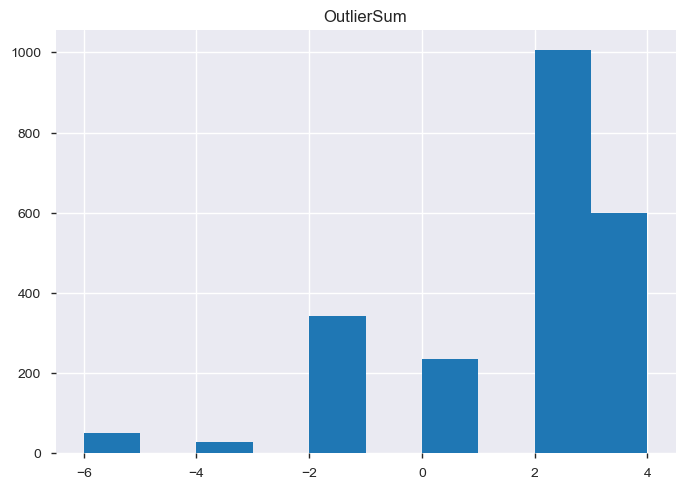

In [87]:
## Create column summing IsoForest
df["OutlierSum"]=df["IsoForest"] + df["IsoForest1"] + df["IsoForest2"] +df["IsoForest2"]+df["Elipt_Envelope"] + df["Elipt_Envelope1"]
df.head()
# 
df1.hist(column="OutlierSum")
# pandas_profiling.ProfileReport(df)
df1=df[df.OutlierSum != 6]
df1.shape

TypeError: scatter() missing 1 required positional argument: 'ys'

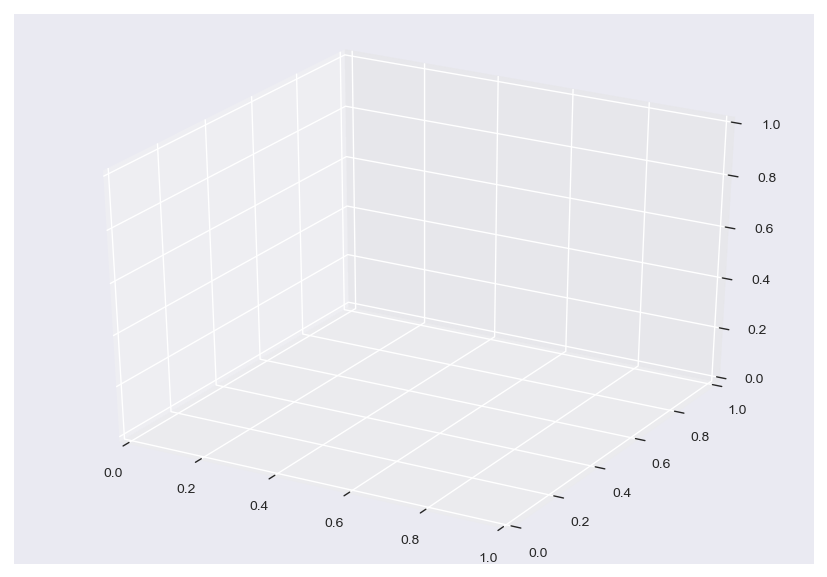

In [79]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(df['INDUS'], boston_df[''])
ax.set_xlabel('Proportion of non-retail business acres per town')
ax.set_ylabel('Full-value property-tax rate per $10,000')
plt.show()